# CELL 1 - Initialization

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import optuna
import random
import kagglehub # Import for the new download method

# --- Constants and Setup ---

IMAGE_SIZE = 100 
BATCH_SIZE = 64
RANDOM_SEED = 42
NUM_EPOCHS_TUNE = 5 # Fewer epochs for quick HPO search
NUM_EPOCHS_FINAL = 50 # Max epochs for final training (with Early Stopping)

# Set random seed for reproducibility
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

# Determine device (CUDA for GPU training)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
if DEVICE.type == 'cuda':
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")


# --- Kaggle Download and DATA_DIR Setup ---
DATASET_ID = "utkarshsaxenadn/fruits-classification"

print(f"\nDownloading Kaggle dataset ID: {DATASET_ID} using kagglehub...")
print("NOTE: This requires your Kaggle API key (kaggle.json) to be set up in ~/.kaggle/.")

try:
    # Use kagglehub to download the dataset
    path = kagglehub.dataset_download(DATASET_ID)
    
    # kagglehub returns the path to the root of the extracted dataset files
    DATA_DIR = str(path)
    
    print("Download complete.")
    print(f"Path to dataset files: {DATA_DIR}")
    
except Exception as e:
    print(f"Kaggle Download Failed. Error: {e}")
    print("Please ensure your Kaggle API key is correctly configured and the kernel is switched.")
    # Fallback path if the download fails for manual placement
    DATA_DIR = './fruits-classification' 
    print(f"Falling back to assumed manual data path: {DATA_DIR}")

Using device: cuda
CUDA device name: NVIDIA GeForce RTX 3060

NOTE: This requires your Kaggle API key (kaggle.json) to be set up in ~/.kaggle/.
Download complete.
Path to dataset files: C:\Users\Bence\.cache\kagglehub\datasets\utkarshsaxenadn\fruits-classification\versions\1


# CELL 2 - Preprocessing

In [2]:
# --- Data Transforms, Normalization, and Features (Data Augmentation) ---

# 1. PIL Image Transforms (Augmentation applied before Tensor conversion)
pil_transforms = [
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomRotation(15), 
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
]

# 2. Tensor Conversion
tensor_conversion = [
    transforms.ToTensor(),
]

# 3. Tensor Transforms (Augmentation and Normalization applied after Tensor conversion)
tensor_transforms = [
    # FIX: RandomErasing MUST be after ToTensor()
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.1), ratio=(0.3, 3.3)), 
    # Normalization
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
]

# Training Transforms (All steps)
train_transforms = transforms.Compose(pil_transforms + tensor_conversion + tensor_transforms)

# Validation/Test Transforms (Only resize, ToTensor, Normalization)
test_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

# --- Adatfolyam (ImageFolder és DataLoader) ---
TRAIN_DIR = DATA_DIR + '\\Fruits Classification\\train'
TEST_DIR = DATA_DIR + '\\Fruits Classification\\test'

train_data = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
test_data = datasets.ImageFolder(TEST_DIR, transform=test_transforms)

# Split training data into training and validation sets (80/20 split)
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_subset, val_subset = torch.utils.data.random_split(train_data, [train_size, val_size])

# Create DataLoaders (Data Streaming)
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

CLASS_NAMES = train_data.classes
NUM_CLASSES = len(CLASS_NAMES)
print(f"Number of Classes: {NUM_CLASSES}")

Number of Classes: 5


# CELL 3 - CNN Model Buildup

In [3]:
class FruitCNN(nn.Module):
    def __init__(self, num_conv_layers, filters, dense_units, dropout_rate, num_classes):
        super(FruitCNN, self).__init__()

        layers = []
        in_channels = 3
        current_img_size = IMAGE_SIZE

        # --- Create 'num_conv_layers' ---
        for i in range(num_conv_layers):
            out_channels = filters * (2**i)
            if out_channels > 512: out_channels = 512

            # --- THE FIX: Add BatchNorm2d ---
            # Order: Conv2d -> BatchNorm -> Activation
            layers += [
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),  # <--- Critical addition
                nn.LeakyReLU(0.1)             # <--- Changed to LeakyReLU to prevent "dead neurons"
            ]

            # Conditional Pooling
            if current_img_size > 4:
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
                current_img_size //= 2

            in_channels = out_channels

        self.features = nn.Sequential(*layers)

        # Calculate flatten size
        with torch.no_grad():
            dummy = torch.zeros(1, 3, IMAGE_SIZE, IMAGE_SIZE)
            feature_map = self.features(dummy)
            flattened_size = feature_map.view(1, -1).size(1)

        # Classifier Head
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout_rate),
            nn.Linear(flattened_size, dense_units),
            nn.BatchNorm1d(dense_units),      # <--- Optional: Helps the dense layer too
            nn.LeakyReLU(0.1),                # <--- Match activation style
            nn.Dropout(dropout_rate),
            nn.Linear(dense_units, num_classes)
            # No Softmax here! (See note below)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# CELL 4 - Hyperparameter optimization

In [9]:
# --- Trainer Function for Optuna (One Epoch) ---
def train_one_epoch_optuna(model, train_loader, optimizer, criterion, device):
    """Trains the model for one epoch."""
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

# --- Evaluator Function for Optuna ---
def evaluate_model_optuna(model, val_loader, device):
    """Evaluates the model on validation data."""
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# --- Optuna Objective Function ---
def objective(trial):
    # --- FIXED CONSTRAINTS ---
    # We do not optimize this anymore, it is hardcoded in the class or passed as fixed.

    # --- SEARCH SPACE ---
    # 1. Filters: Start smaller.
    # With 7 layers, starting at 64 filters means the last layer has 512.
    # That is a LOT of parameters. Trying 32 helps prevent overfitting.
    hp_filters = trial.suggest_categorical('filters', [16, 32, 64])

    # 2. Dense Units
    hp_dense_units = trial.suggest_categorical('dense_units', [128, 256, 512])

    # 3. Regularization (CRITICAL for Deep Nets)
    # We need higher dropout and weight decay to control the 7 layers.
    hp_dropout_rate = trial.suggest_float('dropout_rate', 0.3, 0.6)
    hp_weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True)

    # 4. Learning Rate
    hp_learning_rate = trial.suggest_float('learning_rate', 1e-4, 5e-3, log=True)

    print(f"\n--- Trial {trial.number} (7 Layers) ---")
    print(f"Filters={hp_filters}, LR={hp_learning_rate:.5f}, WD={hp_weight_decay:.5f}")

    # --- Model Setup ---
    # Note: removed num_conv_layers arg since we fixed it in the class above
    # or you can pass it if you kept the init argument: num_conv_layers=7
    # --- Model Setup ---
    model = FruitCNN(
        num_conv_layers=7,  # <--- FIX: Explicitly pass 7 here
        filters=hp_filters,
        dense_units=hp_dense_units,
        dropout_rate=hp_dropout_rate,
        num_classes=NUM_CLASSES
    ).to(DEVICE)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        model.parameters(),
        lr=hp_learning_rate,
        weight_decay=hp_weight_decay
    )

    # --- Training Loop ---
    # Train for 5-8 epochs to see if it converges
    for epoch in range(8):
        train_loss = train_one_epoch_optuna(model, train_loader, optimizer, criterion, DEVICE)
        accuracy = evaluate_model_optuna(model, val_loader, DEVICE)

        trial.report(accuracy, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

# --- Run Optuna Search ---
print("Starting Hyperparameter Optimization (HPO) with Optuna...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print("\n--- Best Trial Results ---")
best_trial = study.best_trial
print(f"Best Validation Accuracy: {best_trial.value:.4f}")
print("Best Hyperparameters:")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")

# Retrieve best hyperparameters
best_hps = best_trial.params

[I 2025-12-21 20:33:27,477] A new study created in memory with name: no-name-2d040a08-6072-44d8-b6b2-3958514d6f88


Starting Hyperparameter Optimization (HPO) with Optuna...

--- Trial 0 (7 Layers) ---
Filters=32, LR=0.00289, WD=0.00023


[I 2025-12-21 20:36:41,246] Trial 0 finished with value: 0.5396907216494845 and parameters: {'filters': 32, 'dense_units': 512, 'dropout_rate': 0.3476619843187833, 'weight_decay': 0.00023206789324510624, 'learning_rate': 0.002893589528472857}. Best is trial 0 with value: 0.5396907216494845.



--- Trial 1 (7 Layers) ---
Filters=16, LR=0.00020, WD=0.00003


[I 2025-12-21 20:39:50,476] Trial 1 finished with value: 0.5618556701030928 and parameters: {'filters': 16, 'dense_units': 256, 'dropout_rate': 0.4938381394337372, 'weight_decay': 3.49943584119877e-05, 'learning_rate': 0.0002016889984402916}. Best is trial 1 with value: 0.5618556701030928.



--- Trial 2 (7 Layers) ---
Filters=32, LR=0.00018, WD=0.00029


[I 2025-12-21 20:44:20,514] Trial 2 finished with value: 0.5685567010309278 and parameters: {'filters': 32, 'dense_units': 512, 'dropout_rate': 0.584654978043567, 'weight_decay': 0.0002896342158117938, 'learning_rate': 0.00018029071477276663}. Best is trial 2 with value: 0.5685567010309278.



--- Trial 3 (7 Layers) ---
Filters=64, LR=0.00431, WD=0.00052


[I 2025-12-21 20:49:24,781] Trial 3 finished with value: 0.4520618556701031 and parameters: {'filters': 64, 'dense_units': 128, 'dropout_rate': 0.41323942860085905, 'weight_decay': 0.0005194953629177313, 'learning_rate': 0.004305516950433401}. Best is trial 2 with value: 0.5685567010309278.



--- Trial 4 (7 Layers) ---
Filters=32, LR=0.00030, WD=0.00004


[I 2025-12-21 20:52:44,675] Trial 4 finished with value: 0.6360824742268041 and parameters: {'filters': 32, 'dense_units': 256, 'dropout_rate': 0.5708571575401713, 'weight_decay': 4.3618409636960205e-05, 'learning_rate': 0.00030462136664848364}. Best is trial 4 with value: 0.6360824742268041.



--- Trial 5 (7 Layers) ---
Filters=16, LR=0.00040, WD=0.00006


[I 2025-12-21 20:53:06,457] Trial 5 pruned. 



--- Trial 6 (7 Layers) ---
Filters=16, LR=0.00109, WD=0.00049


[I 2025-12-21 20:55:28,196] Trial 6 pruned. 



--- Trial 7 (7 Layers) ---
Filters=64, LR=0.00149, WD=0.00002


[I 2025-12-21 20:58:17,558] Trial 7 pruned. 



--- Trial 8 (7 Layers) ---
Filters=32, LR=0.00011, WD=0.00047


[I 2025-12-21 20:58:58,699] Trial 8 pruned. 



--- Trial 9 (7 Layers) ---
Filters=16, LR=0.00248, WD=0.00024


[I 2025-12-21 20:59:37,991] Trial 9 pruned. 



--- Best Trial Results ---
Best Validation Accuracy: 0.6361
Best Hyperparameters:
  filters: 32
  dense_units: 256
  dropout_rate: 0.5708571575401713
  weight_decay: 4.3618409636960205e-05
  learning_rate: 0.00030462136664848364


# CELL 5 - Training, Testing, Validation and Final Evaluation

In [10]:
# --- Final Model Initialization ---
final_model = FruitCNN(
    num_conv_layers=7,
    filters=best_hps['filters'],
    dense_units=best_hps['dense_units'],
    dropout_rate=best_hps['dropout_rate'],
    num_classes=NUM_CLASSES
).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(final_model.parameters(), lr=1e-2) #best_hps['learning_rate']

# --- Custom Early Stopping Logic (Low-Level Logic) ---
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs, device, patience=10):
    
    history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_weights = None
    
    print("Starting Final Training with Early Stopping...")
    
    for epoch in range(1, epochs + 1):
        # Training Phase
        model.train()
        total_train_loss = 0
        for inputs, labels in train_loader:
            # FIX: labels already contains the class indices
            inputs, labels = inputs.to(device), labels.to(device) 
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)

        # Validation Phase
        model.eval()
        total_val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                # FIX: labels already contains the class indices
                correct += (predicted == labels).sum().item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = correct / total
        
        # Log History
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_accuracy'].append(val_accuracy)
        
        print(f'Epoch {epoch}/{epochs}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}')
        
        # Early Stopping Logic 
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            # Save the best weights
            best_model_weights = model.state_dict()
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f"Early stopping at epoch {epoch}. Validation loss did not improve for {patience} epochs.")
                # Restore best weights
                model.load_state_dict(best_model_weights)
                break

    return model, history

# --- Run Final Training ---
final_model, history = train_and_validate(
    final_model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer, 
    NUM_EPOCHS_FINAL, 
    DEVICE
)

Starting Final Training with Early Stopping...
Epoch 1/50: Train Loss: 1.6327, Val Loss: 1.4277, Val Acc: 0.4072
Epoch 2/50: Train Loss: 1.4325, Val Loss: 1.4702, Val Acc: 0.3851
Epoch 3/50: Train Loss: 1.3203, Val Loss: 1.4378, Val Acc: 0.3861
Epoch 4/50: Train Loss: 1.2522, Val Loss: 1.2745, Val Acc: 0.4711
Epoch 5/50: Train Loss: 1.2231, Val Loss: 1.1386, Val Acc: 0.5191
Epoch 6/50: Train Loss: 1.1999, Val Loss: 1.1572, Val Acc: 0.5196
Epoch 7/50: Train Loss: 1.1503, Val Loss: 1.1181, Val Acc: 0.5330
Epoch 8/50: Train Loss: 1.1379, Val Loss: 1.0677, Val Acc: 0.5588
Epoch 9/50: Train Loss: 1.1167, Val Loss: 1.2413, Val Acc: 0.5268
Epoch 10/50: Train Loss: 1.0936, Val Loss: 1.0719, Val Acc: 0.5794
Epoch 11/50: Train Loss: 1.0891, Val Loss: 1.1269, Val Acc: 0.5448
Epoch 12/50: Train Loss: 1.0502, Val Loss: 1.0492, Val Acc: 0.5789
Epoch 13/50: Train Loss: 1.0181, Val Loss: 0.9950, Val Acc: 0.6046
Epoch 14/50: Train Loss: 1.0089, Val Loss: 1.0103, Val Acc: 0.6026
Epoch 15/50: Train Loss:

# CELL 6 - Visualization


--- Training History Visualization ---


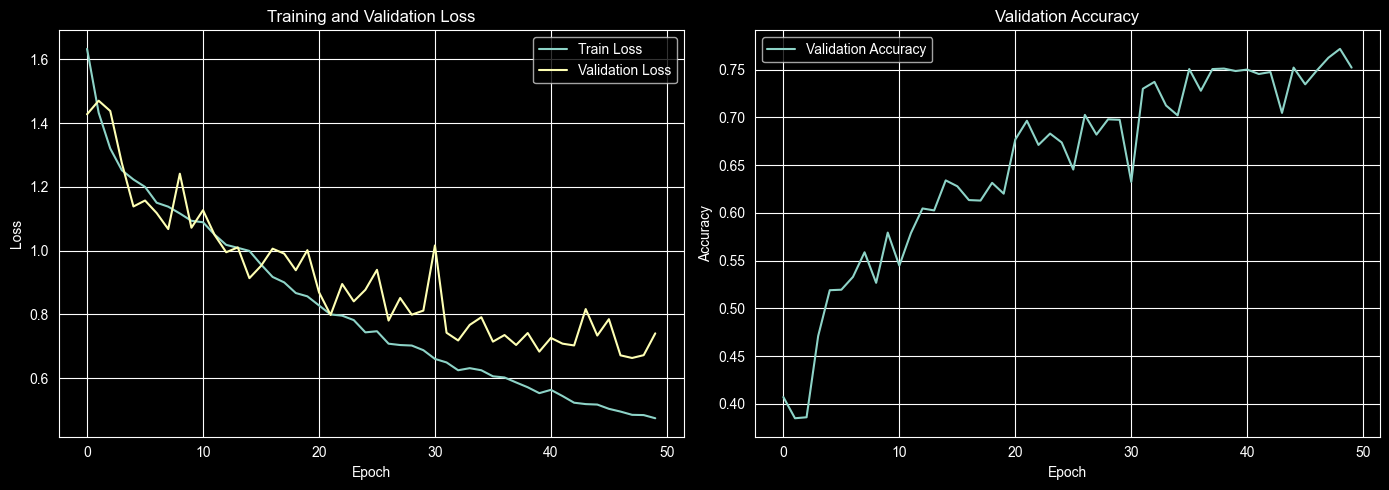


Overall Test Accuracy Score: 85.00%

--- Classification Report ---
              precision    recall  f1-score   support

       Apple     0.8125    0.6500    0.7222        20
      Banana     0.7917    0.9500    0.8636        20
       Grape     1.0000    0.7500    0.8571        20
       Mango     0.7826    0.9000    0.8372        20
  Strawberry     0.9091    1.0000    0.9524        20

    accuracy                         0.8500       100
   macro avg     0.8592    0.8500    0.8465       100
weighted avg     0.8592    0.8500    0.8465       100


--- Confusion Matrix ---


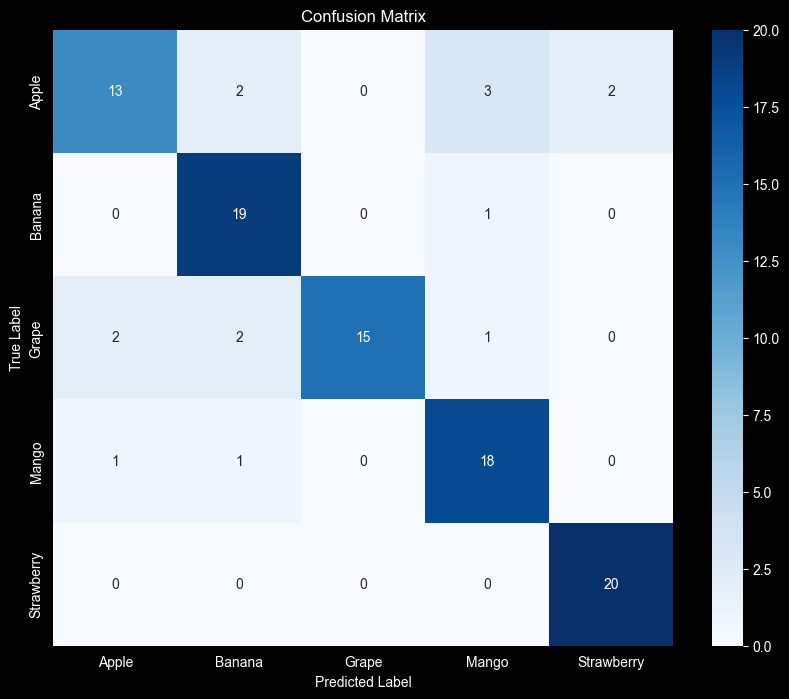

In [11]:
# --- Plot Training History ---
# Plot Training History (Visualization)
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # Plot Loss
    ax[0].plot(history['train_loss'], label='Train Loss')
    ax[0].plot(history['val_loss'], label='Validation Loss')
    ax[0].set_title('Training and Validation Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    # Plot Accuracy
    ax[1].plot(history['val_accuracy'], label='Validation Accuracy')
    ax[1].set_title('Validation Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

# --- Model Evaluation on Test Set ---
def evaluate_test(model, test_loader, device, class_names):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            # FIXED: Removed .argmax(dim=1) because labels are already indices
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Calculate Overall Accuracy Score
    overall_accuracy = accuracy_score(y_true, y_pred)
    print(f"\nOverall Test Accuracy Score: {overall_accuracy*100:.2f}%")

    # Classification Report (F-Score, Recall, Precision)
    print("\n--- Classification Report ---")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    # Confusion Matrix (Visualization)
    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return overall_accuracy

print("\n--- Training History Visualization ---")
plot_history(history)

# --- Run Test Evaluation ---
# Ensure your class_names list matches the number of classes in the model
test_accuracy = evaluate_test(final_model, test_loader, DEVICE, CLASS_NAMES)